# Ahmet Onur AKMAN
## 16011059

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
import requests

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import IsolationForest


from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

# Preparing the dataframe

### Scanning data

In [2]:
df = pd.read_csv('qsar_oral_toxicity.csv', names=['fingerprint0'], header = None)
df.head()

,fingerprint0
0,0;0;0;0;0;0;0;0;0;0;1;0;0;0;0;0;1;0;0;0;0;0;0;...
1,0;0;1;0;0;0;0;0;0;0;1;0;0;0;0;0;1;0;0;0;0;0;0;...
2,0;0;0;0;0;0;0;0;0;0;1;0;0;0;0;0;1;0;0;0;0;0;0;...
3,0;0;0;0;0;0;0;1;0;0;1;0;0;0;0;0;1;0;0;0;0;0;0;...
4,0;0;0;0;0;0;0;0;0;0;0;0;0;1;0;0;1;0;0;0;0;0;0;...


In [3]:
fp = [line['fingerprint0'].split(";") for line in df.iloc]

del df['fingerprint0']
df.insert(0, 'fingerprint', fp, True)
print(len(df['fingerprint'][0]))

1025


In [4]:
df.insert(1, 'toxicity', [line['fingerprint'][-1]=='positive' for line in df.iloc], True)
df['fingerprint'] = [line['fingerprint'][:-1] for line in df.iloc]
print(len(df['fingerprint'][1]), "features!")
df.head()

1024 features!


,fingerprint,toxicity
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",False
1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",False
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",False
3,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...",False
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",False


### Seperating fingerprint cells

In [5]:
for i in range (len(df['fingerprint'][1])):
    df.insert(i+1, 'fp_'+str(i), [x[i] for x in df['fingerprint']], True)
    
del df['fingerprint']
df.head()

,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,fp_8,fp_9,...,fp_1015,fp_1016,fp_1017,fp_1018,fp_1019,fp_1020,fp_1021,fp_1022,fp_1023,toxicity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,False
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,False
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False


### After preparing our dataframe, we can see that we have 1024 fingerprint digits, which are expressed in binary form, and one toxicity class, which can either be True of False.

# Missing Values

In [6]:
null_counter = 0
for column in df:
    nr_of_nulls = len([x for x in df[column].isnull() if x])
    #print(column, nr_of_nulls)
    null_counter += nr_of_nulls
print("Total number of null cells in general:", null_counter)

Total number of null cells in general: 0


### Out dataset is complete!

# Outliers

In [7]:
target = 'toxicity'
labels = [f for f in df.columns]
labels.remove(target)

In [8]:
iso = IsolationForest(contamination='auto', behaviour='new')
out_results = iso.fit_predict([x[labels] for x in df.iloc], y = [x[target] for x in df.iloc])

In [9]:
print(len([i for i in range(len(out_results)) if out_results[i]==-1]), "outliers\n")
#print([i for i in range(len(out_results)) if out_results[i]==-1])

213 outliers



In [10]:
df = df.drop(index = [i for i in range(len(out_results)) if out_results[i]==-1])
df = df.reset_index(drop=True)
print("New dataset shape:", df.shape)
#df.head()

New dataset shape: (8779, 1025)


### Considering the data type we have in our dataset, methods like boxplot does not seem to be the way to follow for outlier/anomaly detection.
### That's why I implemented a way to isolate outlier samples with the help of Isolation Forest, which is an unsupervised ML algorithm and seemed to be working alright.
### The idea is somewhat similar to the decision tree algorithm. A scheme of its way of working is given below.

<img src="https://www.researchgate.net/profile/Yong-Gwan-Lee/publication/341629782/figure/fig3/AS:895252202270728@1590456166469/Overview-of-the-isolation-forest-method-Light-green-circles-represent-common-normal.ppm">

### Note: Due to the randomness in the nature of Isolation Forest, rest of the program will be highly affected by the result of this block. In the report, last compile results were regarded, however, when you run it at some other time, the results of the classifiers and clustering algorithms might change.

# Balancing data

### Our dataset is not balanced. For capturing higher accuracy scores, it needs to be balanced.

False    8055
True      724
Name: toxicity, dtype: int64


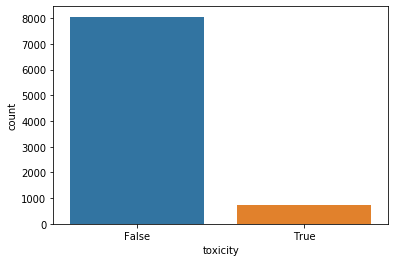

In [11]:
print(df[target].value_counts())
sns.countplot(x=df[target], label='count')

###### This takes some time

In [12]:
pst = df[df[target]==True]
neg = df[df[target]==False]

counter = df[target].value_counts()[True]
new_df = pd.DataFrame([], columns = [f for f in df.columns])

for i in range (counter):
    new_df = new_df.append([pst.iloc[i]])
    new_df = new_df.append([neg.iloc[i]])
    
df = new_df.copy()
df = df.reset_index(drop=True)
df.head()

,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,fp_8,fp_9,...,fp_1015,fp_1016,fp_1017,fp_1018,fp_1019,fp_1020,fp_1021,fp_1022,fp_1023,toxicity
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,True
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True


### Here, intstead of using (possibly more convenient) libraries, I decided to do the balancing & shuffling task on my own. You can see that at first, I have seperated the members of the two classes, and then relocated them homogeneously. I also eliminated the extra rows for having the equal amount from the each class.

True     724
False    724
Name: toxicity, dtype: int64


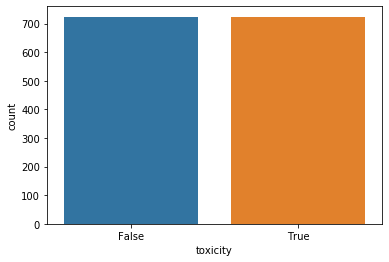

In [13]:
print(df[target].value_counts())
sns.countplot(x=df[target], label='count')

# How selective are the features

#### You might remember the following functions from my previous homework.

In [14]:
def getEntropy(df_label): # Calculating entropy from the df label
    targets, counts = np.unique(df_label, return_counts = True)
    entropy = 0
    for idx in range(len(targets)):
        entropy += ((-1*counts[idx])/np.sum(counts))*(np.log2(counts[idx]/np.sum(counts)))
    return entropy

def getInformationGain(data, feat, label): # Calculating info gain with weighted entropy
    values, counts = np.unique(data[feat], return_counts = True)
    weightedEntropy = 0
    for idx in range(len(values)):
        weightedEntropy += (counts[idx]/np.sum(counts)) * getEntropy(data.where(data[feat]==values[idx]).dropna()[label])
    return (getEntropy(data[label]) - weightedEntropy)

###### This takes some time

In [15]:
info_gain = [getInformationGain(df, label, target) for label in labels]

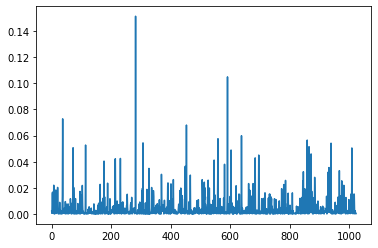

In [16]:
plt.plot(info_gain)
plt.show()

### This graph shows us the information gain score of the each feature we have in our dataset.

# Feature Selection

#### I added this section to enable the feature selection according to the information gain score. However, I observed that eliminating features lowers the accuracy, almost everytime. 
### That's why I did not run these two blocks below.

In [205]:
selectiveness_threshold = 0.001

selected_labels = []
for idx in range (len(labels)):
    if info_gain[idx] > selectiveness_threshold:
        selected_labels.append(labels[idx])

In [206]:
labels = selected_labels

# Training

In [33]:
X = df[labels].values
y = df[target].values.astype('bool')

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.1, random_state = 0, shuffle = True)

# --- Classification ---

## Multinomial Naive Bayes

#### MN Naive Bayes is a simple approach to the classification problems. It mainly relies on the probability of the class within all the classes available, as well as the predictor prior probability. These are also called marginal probability. The formulation that is used in the classification is shown below.

<img src="https://camo.githubusercontent.com/effd9fb83c22c895f58f8948704dd80086ff7d24f153564257da8e1e8ef205a7/687474703a2f2f75632d722e6769746875622e696f2f7075626c69632f696d616765732f616e616c79746963732f6e616976655f62617965732f6e616976655f62617965735f69636f6e2e706e67">

In [34]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

              precision    recall  f1-score   support

       False       0.76      0.87      0.81        68
        True       0.87      0.75      0.81        77

    accuracy                           0.81       145
   macro avg       0.81      0.81      0.81       145
weighted avg       0.81      0.81      0.81       145



(2, 0)

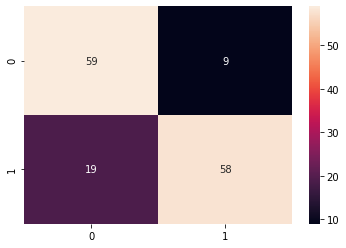

In [35]:
nb_predict_test = nb_classifier.predict(X_test)
nb_conMtx = confusion_matrix(y_test, nb_predict_test)

print(classification_report(y_test, nb_predict_test))
sns.heatmap(nb_conMtx, annot= True).set_ylim(2, 0)

## K-Nearest Neighbors

#### KNN algorithm is a classifier algorithm which relies on the factor of distance between the point to be predicted and other points on the space, which we already know the classes of. After considering the closest neighbors' classes, new point is classified with the outcome of this consideration. A simple visual about its way of working is given below.

<img src="https://www.researchgate.net/profile/Saleh-Alaliyat/publication/267953942/figure/fig14/AS:295388776026147@1447437580523/K-nearest-neighbor-algorithm-illustration-The-green-circle-is-the-sample-which-is-to-be.png">

In [36]:
kn_classifier = KNeighborsClassifier()
kn_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

              precision    recall  f1-score   support

       False       0.78      0.88      0.83        68
        True       0.88      0.78      0.83        77

    accuracy                           0.83       145
   macro avg       0.83      0.83      0.83       145
weighted avg       0.83      0.83      0.83       145



(2, 0)

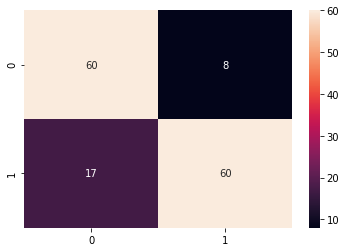

In [37]:
kn_predict_test = kn_classifier.predict(X_test)
kn_conMtx = confusion_matrix(y_test, kn_predict_test)

print(classification_report(y_test, kn_predict_test))
sns.heatmap(kn_conMtx, annot= True).set_ylim(2, 0)

## Logistic Regression

#### Logistic Regression, as its name suggests, is a regression algorithm which aims to provide a mathematical solution for the given problem by estimating the parameters of a logistic model. It simply predicts the categorical dependent variable using a provided set of distinct independent values.

<img src="https://saedsayad.com/images/LogReg_1.png">

In [38]:
lr_classifier = LogisticRegression(random_state=0, solver='newton-cg')
lr_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

       False       0.88      0.87      0.87        68
        True       0.88      0.90      0.89        77

    accuracy                           0.88       145
   macro avg       0.88      0.88      0.88       145
weighted avg       0.88      0.88      0.88       145



(2, 0)

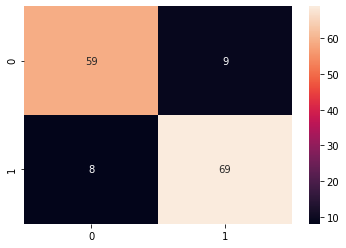

In [39]:
lr_predict_test = lr_classifier.predict(X_test)
lr_conMtx = confusion_matrix(y_test, lr_predict_test)

print(classification_report(y_test, lr_predict_test))
sns.heatmap(lr_conMtx, annot= True).set_ylim(2, 0)

# --- Clustering ---

### In classifiers, we used a training set with features and class to train the model, and then tested the trained model with a similat test set. However, we do not use class information when we create our clustering model. That is why, instead of using two distinct training and testing data, we will cluster the whole data at first, and then measure the ability of clustering by checking the class info of the data in the same cluster.

## K-Means

#### K-Means algorithm is used for clustering the given set of variables on the space into n clusters. The k-means problem is solved using either Lloyd’s or Elkan’s algorithm. A schematic about its clustering process is given below.

<img src="https://stanford.edu/~cpiech/cs221/img/kmeansViz.png">

In [24]:
km_cluster = KMeans(n_clusters = 2, random_state = 0)
km_cluster.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [25]:
acc1 = len([i for i in range(len(y)) if y[i] == km_cluster.labels_[i]])
acc2 = len([i for i in range(len(y)) if y[i] == (1-km_cluster.labels_[i])])

pred = []
if acc1<acc2:
    km_pred = 1-km_cluster.labels_
else:
    km_pred = km_cluster.labels_

#### Clustering might be done with opposite labels. For instance, even if the clustering is done perfectly, the label of each cluster can be switched, considering the algorithms do not use the class info for clustering. The block above checks which label placement should be recognized for success measurement.

              precision    recall  f1-score   support

       False       0.51      0.48      0.50       724
        True       0.51      0.54      0.53       724

    accuracy                           0.51      1448
   macro avg       0.51      0.51      0.51      1448
weighted avg       0.51      0.51      0.51      1448



(2, 0)

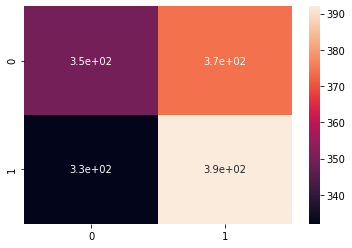

In [26]:
km_conMtx = confusion_matrix(y, km_pred)

print(classification_report(y, km_pred))
sns.heatmap(km_conMtx, annot= True).set_ylim(2, 0)

## Agglomerative Clustering

#### Agglomerative Clustering, which performs Hierarchical clustering, is a clustering algorithm that solves the clustering problem by creating nested clusters by merging or splitting them successively. The hierarchy of clusters can be visualized as a tree. Explanatory visual is given below.

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20190508025311/781ff66c-b380-4a78-af25-80507ed6ff26-300x300.png">

In [27]:
ag_cluster = AgglomerativeClustering(n_clusters = 2)
ag_cluster.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2,
                        pooling_func='deprecated')

In [28]:
acc1 = len([i for i in range(len(y)) if y[i] == ag_cluster.labels_[i]])
acc2 = len([i for i in range(len(y)) if y[i] == (1-ag_cluster.labels_[i])])

pred = []
if acc1<acc2:
    ag_pred = 1-ag_cluster.labels_
else:
    ag_pred = ag_cluster.labels_

#### Clustering might be done with opposite labels. For instance, even if the clustering is done perfectly, the label of each cluster can be switched, considering the algorithms do not use the class info for clustering. The block above checks which label placement should be recognized for success measurement.

              precision    recall  f1-score   support

       False       0.54      0.53      0.54       724
        True       0.54      0.55      0.55       724

    accuracy                           0.54      1448
   macro avg       0.54      0.54      0.54      1448
weighted avg       0.54      0.54      0.54      1448



(2, 0)

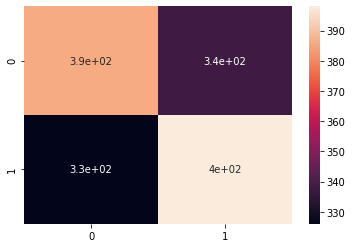

In [29]:
ag_conMtx = confusion_matrix(y, ag_pred)

print(classification_report(y, ag_pred))
sns.heatmap(ag_conMtx, annot= True).set_ylim(2, 0)

## Spectral Clustering

#### Spectral Clustering is better known as a successful algorithm when it comes to clustering a set of values that cannot be easily distinguished by other algorithms by spreading on the space. It uses the method of dimensionality reduction in order to perform clustering a data set which is the spread of the cluster is not a suitable description of the complete cluster. To better understand its usage, an explanatory visual which focuses on the comparison of SC to K-Means is given below.

<img src="https://www.researchgate.net/profile/Abdelkarim-Ben-Ayed/publication/319284000/figure/fig1/AS:594272629825536@1518697044688/Comparison-between-K-Means-and-spectral-clustering.png">

###### This takes some time

In [30]:
sc_cluster = SpectralClustering(n_clusters=2, assign_labels='kmeans', random_state=0)
sc_cluster.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=None,
                   n_neighbors=10, random_state=0)

In [31]:
acc1 = len([i for i in range(len(y)) if y[i] == sc_cluster.labels_[i]])
acc2 = len([i for i in range(len(y)) if y[i] == (1-sc_cluster.labels_[i])])

pred = []
if acc1<acc2:
    sc_pred = 1-sc_cluster.labels_
else:
    sc_pred = sc_cluster.labels_

#### Clustering might be done with opposite labels. For instance, even if the clustering is done perfectly, the label of each cluster can be switched, considering the algorithms do not use the class info for clustering. The block above checks which label placement should be recognized for success measurement.

              precision    recall  f1-score   support

       False       0.50      1.00      0.67       724
        True       1.00      0.00      0.00       724

    accuracy                           0.50      1448
   macro avg       0.75      0.50      0.33      1448
weighted avg       0.75      0.50      0.33      1448



(2, 0)

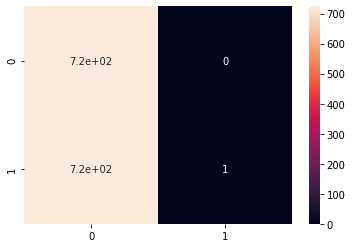

In [32]:
sc_conMtx = confusion_matrix(y, sc_pred)

print(classification_report(y, sc_pred))
sns.heatmap(sc_conMtx, annot= True).set_ylim(2, 0)

## Classifiers

#### It was observed that classifiers overall achieved >~80% general accuracy. Highest average accuracy amongst 2 classes is achieved with the Logistic Regression algorithm.
#### Classifiers seemed to have a adequate accuracy for both classes. Algorithms achieved near %80 precision for both classes, it shows that selected algorithms are successful at distinguishing between classes.
#### It can be seen that algorithms are generally more successful on classifying "True" class data correctly.
#### Visually, confusion matrices show generally how successfull the algorithms are at the classification of the test data.

## Clusterers

#### Unlike the results obtained from classifiers, clustering algorithms barely could achieve the accuracy of ~50%. 
#### Even though spectral clustering algorithms achieved the 50% accuracy percentage, it can be seen that its recall score on "False" labelled values are extremely low. This shows that the model shows an extremely poor performance on classifying new data, even though its accuracy is relatively high. This score is achieved because the model tends to classify every value as "True", and the test set is evenly distributed.
#### From confusion matrices, other two clustering algorithms seem to be extremely undecisive on data classification, almost perfect even dsitribution for each cell on the matrices is observed.

<img src="https://i.hizliresim.com/fpjn7y7.png">